# Notebook with final graph

### !!! Move this notebook to root directory before executing it

#### Imports

In [8]:
import getpass
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd() + "./../")))

import json
import operator
from typing import Annotated

from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel
from typing_extensions import TypedDict

from src.agents.agentic_tools import modifiers, special_hits
from src.prompts.prompts import (
    FIGHT_EVOLUTION_PROMPT,
    FIGHTERS_MOVES_PROMPT,
    NARRATOR_PROMPT,
    ORCHESTRATOR_PROMPT,
    SCENARIO_PROMPT,
    UPDATER_PROMPT,
)
from src.utils.databases import (
    add_exp_to_winner,
    add_fighter,
    create_tables,
    get_fighter_info,
    update_leaderboard,
    update_scores,
)
from src.utils.utils import pop_persisted_keys, tprint

#### State class definition

In [9]:
class FightState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    fight_evolution: Annotated[list[str], operator.add]

    round: int = 0
    modifiers: str

    winner: str
    loser: str

    # Fighter 1
    fighter1_name: str
    fighter1_description: str
    fighter1_health: float
    fighter1_strength: int
    fighter1_agility: int
    fighter1_intelligence: int
    fighter1_armor: int
    fighter1_tiredness: int = 0
    fighter1_move: str

    # Fighter 2
    fighter2_name: str
    fighter2_description: str
    fighter2_health: float
    fighter2_strength: int
    fighter2_agility: int
    fighter2_intelligence: int
    fighter2_armor: int
    fighter2_tiredness: int = 0
    fighter2_move: str

#### AgenticFight class definition

Contains:
- graph initialization
- node definition
- node relations
- graph compilations

In [10]:
class AgenticFight:
    MAX_ROUNDS = 3

    def __init__(self, model, tools, checkpointer=None):
        self.model = model

        # Graph
        builder = StateGraph(FightState)

        # Set nodes
        builder.add_node("prepare_fight", self.prepare_fight)
        builder.add_node("characters_moves", self.characters_moves)
        builder.add_node("orchestrator", self.orchestrator)
        builder.add_node("tools", ToolNode(tools))
        builder.add_node("narrator", self.narrator)
        builder.add_node("updater", self.updater)

        # Logic
        builder.add_edge(START, "prepare_fight")
        builder.add_edge("prepare_fight", "characters_moves")
        builder.add_edge("characters_moves", "orchestrator")
        builder.add_conditional_edges(
            "orchestrator",
            self.route_tools,
            {"tools": "tools", "narrator": "narrator"},
        )
        builder.add_edge("tools", "orchestrator")
        builder.add_conditional_edges(
            "narrator",
            self.fight_continues,
            {"characters_moves": "characters_moves", "updater": "updater"},
        )
        builder.add_edge("updater", END)

        # Compile graph
        self.graph = builder.compile(checkpointer=checkpointer)

    # Nodes
    ########
    @staticmethod
    def prepare_fight(state: FightState):
        # Create database and tables, if they do not exist
        create_tables()
        tprint("Tables created!")

        # Get fighters info and try to update the fighters table
        with open("./src/prompts/fighters.json", "r", encoding="utf-8") as f:
            fighters_info = json.load(f)
        add_fighter(fighters_info["fighter1"])
        add_fighter(fighters_info["fighter2"])
        tprint("Fighters added to database!")

        # Get latest fighter info
        fighter1_info = get_fighter_info(fighters_info["fighter1"]["name"])
        fighter2_info = get_fighter_info(fighters_info["fighter2"]["name"])
        state.update(
            {
                "fighter1_name": fighter1_info["name"],
                "fighter1_description": fighter1_info["description"],
                "fighter1_health": fighter1_info["health"],
                "fighter1_strength": fighter1_info["strength"],
                "fighter1_agility": fighter1_info["agility"],
                "fighter1_intelligence": fighter1_info["intelligence"],
                "fighter1_armor": fighter1_info["armor"],
                "fighter1_tiredness": fighter1_info["tiredness"],
                "fighter2_name": fighter2_info["name"],
                "fighter2_description": fighter2_info["description"],
                "fighter2_health": fighter2_info["health"],
                "fighter2_strength": fighter2_info["strength"],
                "fighter2_agility": fighter2_info["agility"],
                "fighter2_intelligence": fighter2_info["intelligence"],
                "fighter2_armor": fighter2_info["armor"],
                "fighter2_tiredness": fighter2_info["tiredness"],
            }
        )
        tprint("Fighters info retrieved and updated!")

        # Add prompts
        state["fight_evolution"] = [
            FIGHT_EVOLUTION_PROMPT.format(
                scenario=SCENARIO_PROMPT,
                fighter1_name=state["fighter1_name"],
                fighter1_description=state["fighter1_description"],
                fighter2_name=state["fighter2_name"],
                fighter2_description=state["fighter2_description"],
            )
        ]
        tprint("Prompts assigned!")

        # Set some state variables
        state["round"] = 0
        state["modifiers"] = ""

        state = pop_persisted_keys(state, keys=["messages"])

        return state

    @staticmethod
    def characters_moves(state: FightState):
        # Human feedback node

        state["round"] += 1
        state["fight_evolution"] = [f"COMIENZA LA RONDA {state['round']}!"]
        tprint(f"COMIENZA LA RONDA {state['round']}!")

        state["fighter1_move"] = input("Fighter 1 move: ")
        state["fighter2_move"] = input("Fighter 2 move: ")

        state["messages"] = [
            HumanMessage(
                content=FIGHTERS_MOVES_PROMPT.format(
                    fighter1_name=state["fighter1_name"],
                    fighter1_move=state["fighter1_move"],
                    fighter2_name=state["fighter2_name"],
                    fighter2_move=state["fighter2_move"],
                )
            )
        ]

        tprint(state["messages"][-1].content)

        return state

    def orchestrator(self, state: FightState):
        query_modifiers = ORCHESTRATOR_PROMPT.format(
            fight_evolution=state["fight_evolution"],
            fighters_moves=state["messages"][-1].content,
            modifiers=state["modifiers"],
        )

        # TODO: solve generation issue
        import random

        state["modifiers"] = (
            f"Fighter {random.choice(['1', '2'])} hit multiplier: {random.choices([0.5, 1, 1.5, 2], weights=[0.1, 0.6, 0.2, 0.1], k=1)[0]}"
        )
        # result = self.model.invoke([HumanMessage(content=query_modifiers)])
        # tprint.warning(result)

        # state["messages"] = [result]

        tprint(f"Modifiers - {state['modifiers']}")

        state = pop_persisted_keys(state, keys=["fight_evolution"])

        return state

    def narrator(self, state: FightState):
        context = NARRATOR_PROMPT.format(
            fight_evolution=state["fight_evolution"],
            fighter1_name=state["fighter1_name"],
            fighter1_move=state["fighter1_move"],
            fighter2_name=state["fighter2_name"],
            fighter2_move=state["fighter2_move"],
            modifiers=state["modifiers"],
            fighter1_health=state["fighter1_health"],
            fighter1_strength=state["fighter1_strength"],
            fighter1_agility=state["fighter1_agility"],
            fighter1_intelligence=state["fighter1_intelligence"],
            fighter1_armor=state["fighter1_armor"],
            fighter1_tiredness=state["fighter1_tiredness"],
            fighter2_health=state["fighter2_health"],
            fighter2_strength=state["fighter2_strength"],
            fighter2_agility=state["fighter2_agility"],
            fighter2_intelligence=state["fighter2_intelligence"],
            fighter2_armor=state["fighter2_armor"],
            fighter2_tiredness=state["fighter2_tiredness"],
        )

        result = self.model.with_structured_output(RoundResult).invoke(context)
        state["fighter1_health"] = result.health_remaining_fighter1
        state["fighter2_health"] = result.health_remaining_fighter2

        state["fight_evolution"] = [result.round_development]
        tprint(result.round_development)

        # Reset modifiers state
        state["modifiers"] = ""

        state = pop_persisted_keys(state, keys=["messages"])

        return state

    def updater(self, state: FightState):
        # Get results from the fight
        fight_evolution = ["FIN DE LA PELEA!"]
        tprint(fight_evolution)

        context = UPDATER_PROMPT.format(fight_evolution=state["fight_evolution"])
        result = self.model.with_structured_output(EndOfFight).invoke(context)
        tprint(result)

        state["winner"] = result.winner
        state["loser"] = result.loser

        fight_evolution.append(
            f"GANADOR: {state['winner']}\nPERDEDOR: {state['loser']}"
        )
        state["fight_evolution"] = [fight_evolution]

        tprint(fight_evolution)

        # Update leaderboard
        if not result.draw:
            update_leaderboard(state["winner"], state["loser"])
        else:
            # TODO: define case when draw
            pass
        update_scores()

        # Add exp to winner
        add_exp_to_winner(state["winner"])

        # Update tiredness
        # TODO: add tiredness logic

        # Level-up
        # TODO: add level-up logic

        # Reset state variables
        # TODO: reset state variables

        state = pop_persisted_keys(state, keys=["messages"])

        return state

    # Conditional edges' conditions
    @staticmethod
    def route_tools(state: FightState):
        """
        Used in the conditional_edge to route to the ToolNode if the last message
        has tool calls. Otherwise, route to the 'narrator'.
        """
        if isinstance(state, list):
            ai_message = state[-1]
        elif messages := state["messages"]:
            ai_message = messages[-1]
        else:
            raise ValueError(f"No messages found in input state to tool_edge: {state}")

        if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
            return "tools"

        return "narrator"

    @classmethod
    def fight_continues(cls, state: FightState):
        """Condition to go to the next round or end the fight."""

        # If the fight has gone over MAX_ROUNDS rounds, fight is over
        if state["round"] >= cls.MAX_ROUNDS:
            return "updater"

        # If any fighter has no health left, fight is over
        if state["fighter1_health"] <= 0 or state["fighter2_health"] <= 0:
            return "updater"

        return "characters_moves"


# Structured ouputs
class RoundResult(BaseModel):
    round_development: str
    health_remaining_fighter1: int
    health_remaining_fighter2: int


class EndOfFight(BaseModel):
    winner: str
    loser: str
    draw: bool

#### Prepare execution

In [11]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
# _set_env("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "agentic-fighters"

# Create llm instance and add tools
llm = ChatOpenAI(model="gpt-4o-mini", temperature=1)
tools = [special_hits]  # , modifiers]
llm_with_tools = llm.bind_tools(tools)

In [12]:
thread = {"configurable": {"thread_id": "fight1"}}
abot = AgenticFight(llm_with_tools, tools)

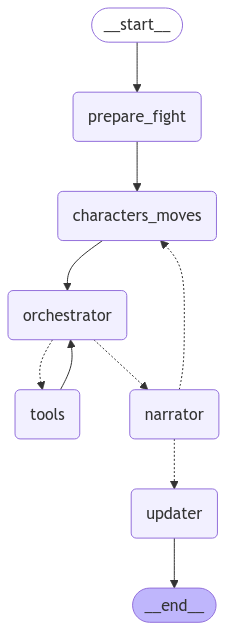

In [13]:
from IPython.display import Image

# Image(graph.get_graph().draw_png())
Image(abot.graph.get_graph().draw_mermaid_png())

#### Invoke whole graph

In [ ]:
result = abot.graph.invoke({"messages": SystemMessage("Execute")})
result

Tables created!

Fighters added to database!

Fighters info retrieved and updated!

Prompts assigned!

COMIENZA LA RONDA 1!

Aquí tienes el siguiente movimiento del luchador 1 (Carlos): patada

Aquí tienes el siguiente movimiento del luchador 2 (Alejandro): golpe


Modifiers - Fighter 2 hit multiplier: 1.5

La niebla en las montañas parece cobrar vida mientras comienza la Ronda 1 de esta épica lucha. Carlos y Alejandro se miran con determinación, como dos halcones en un duelo de miradas intensas. Carlos, con su patada lista, parece recordar los días en que corría como un venado y saltaba como un canguro, pero por ahora va a optar por un movimiento más... alcanzable.

Carlos se lanza en un salto acrobático, visualizando su patada como una obra maestra de arte marcial, pero en el aire, parece más una hoja de papel en el viento. Su patada va hacia Alejandro, quien observa la acción con una mezcla de curiosidad y asombro. ¡Qué facilidad tiene para tirarse hacia el lado equivocado!

Mientra

{'messages': ['Test',
  HumanMessage(content='Aquí tienes el siguiente movimiento del luchador 1 (Carlos): patada\n\nAquí tienes el siguiente movimiento del luchador 2 (Alejandro): golpe\n', additional_kwargs={}, response_metadata={}),
  'Test',
  HumanMessage(content='Aquí tienes el siguiente movimiento del luchador 1 (Carlos): patada\n\nAquí tienes el siguiente movimiento del luchador 2 (Alejandro): golpe\n', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Aquí tienes el siguiente movimiento del luchador 1 (Carlos): esquiva\n\nAquí tienes el siguiente movimiento del luchador 2 (Alejandro): puñetazo\n', additional_kwargs={}, response_metadata={}),
  'Test',
  HumanMessage(content='Aquí tienes el siguiente movimiento del luchador 1 (Carlos): patada\n\nAquí tienes el siguiente movimiento del luchador 2 (Alejandro): golpe\n', additional_kwargs={}, response_metadata={}),
  'Test',
  HumanMessage(content='Aquí tienes el siguiente movimiento del luchador 1 (Carlos): pat